In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

In [3]:
TOPICS = ["Astronomy", "Health", "Economy"]
TOPICS_MAP = {"Astronomy": 0, "Health": 1, "Economy": 2}

In [4]:
def create_dataset(topics):
    data = {'hash':[],'topic': [], 'text': []}
    for topic in topics:
        for file in os.listdir(f"Documents/{topic}"):
            with open(f"Documents/{topic}/{file}", "r", encoding="utf-8") as f:
                text = f.read()
                data['hash'].append(file)
                data['topic'].append(topic)
                data['text'].append(text)
    return pd.DataFrame(data)

data = create_dataset(TOPICS)
data

,hash,topic,text
0,070c9fd24e43ba164f3a68dd8c976a57461fceb038a43d...,Astronomy,cosmic countdown begun director james gunn ’ `...
1,09559783f5ee1852885289ba8fd16625284625dd41875e...,Astronomy,planetary society taking stand nasa 's stalled...
2,09d01585d21facc6f893ec9c64a6d79ffc107be243f10d...,Astronomy,may helpful receive news updates notifications...
3,0a3d8dfb0821ff1ed7ad6fd00ad318c667f9300b37ea71...,Astronomy,spacex falcon 9 rocket used first stage launch...
4,0fec84f3a3c7ce5499f3c51206b058400502e683b9faed...,Astronomy,new image james webb space telescope ( jwst ) ...
...,...,...,...
310,ea76c0512e9f17c1ea3081e7ac4ea6adcd9a4b7d9d82b3...,Economy,dow jones networkintraday data provided factse...
311,eb4f1d242dabdaf922cf393940d3fd1c18c8c1a3c271f6...,Economy,dow jones networkintraday data provided factse...
312,eea2c24632f92505ff2ca5943b32cbbecc275108b6d161...,Economy,10-yr bondnasdaqvolatilityftsenikkei 225cad/eu...
313,f0b07ab98c445e62cfbed189b95c7414c45c1c28256329...,Economy,spike oil prices surprise opec+ production cut...


In [5]:
def preprocess(data,topics_map):
    tokenizer = RegexpTokenizer(r'\w+')
    data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['text'] = data['text'].apply(lambda x: ' '.join(x))
    data['label'] = data['topic'].map(topics_map)
    X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess(data,TOPICS_MAP)
X_train

64     earth observationcanadian space agency csa rec...
34     exciting news lego star wars fans lego announc...
210    cad eurottawa gives final approval conditions ...
266    cad eur u s labor market undoubtedly strongest...
81     purchase links site may earn affiliate commiss...
                             ...                        
251    thursday tesla cut prices united states 2 near...
192    kidney stone small hard substance made waste p...
117    editorial processhealthline committed providin...
47     photographer nafe alamri took photo hybrid ecl...
172    given new evidence b 1 617 2 delta variant cdc...
Name: text, Length: 252, dtype: object

In [6]:
def create_tf_idf(X_train,X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf
X_train_tfidf, X_test_tfidf = create_tf_idf(X_train,X_test)
X_train_tfidf

<252x18055 sparse matrix of type '<class 'numpy.float64'>'
	with 85171 stored elements in Compressed Sparse Row format>

In [7]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_validate_and_train(model,X_train_tfidf,y_train):
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score,average='macro'),
           'recall': make_scorer(recall_score, average='macro'),
           'f1_score': make_scorer(f1_score, average='macro')}
    K_folds = 5
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=K_folds, scoring=scoring, return_estimator=True)
    for i in range(K_folds):
        print(f"Fold: {i+1}")
        print(f"Accuracy: {cv_results['test_accuracy'][i]}")
        print(f"Precision: {cv_results['test_precision'][i]}")
        print(f"Recall: {cv_results['test_recall'][i]}")
        print(f"F1 Score: {cv_results['test_f1_score'][i]}")
        print("\n")
    print("Mean Metrics")
    print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
    print(f"Mean Precision: {np.mean(cv_results['test_precision'])}")
    print(f"Mean Recall: {np.mean(cv_results['test_recall'])}")
    print(f"Mean F1 Score: {np.mean(cv_results['test_f1_score'])}")

    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    best_metric = max(mean_scores, key=mean_scores.get)
    best_estimator_index= np.argmax(cv_results['test_'+best_metric])
    best_estimator = cv_results['estimator'][best_estimator_index]
    print(f"Best Estimator: {best_estimator_index}")
    return best_estimator

In [8]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, RocCurveDisplay
def test_model(model,X_test_tfidf,y_test, plot=False):
    print("Test Metrics")
    y_pred = model.predict(X_test_tfidf)
    #Test to see if predict_proba works
    _ = model.predict_proba(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    if plot:
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
        plt.show()
    return report

Model: SVC
Fold: 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 2
Accuracy: 0.9607843137254902
Precision: 0.9649122807017544
Recall: 0.9607843137254902
F1 Score: 0.9606481481481483


Fold: 3
Accuracy: 0.96
Precision: 0.9649122807017544
Recall: 0.9583333333333334
F1 Score: 0.9592592592592593


Fold: 4
Accuracy: 0.98
Precision: 0.9814814814814815
Recall: 0.9791666666666666
F1 Score: 0.9797235023041475


Fold: 5
Accuracy: 0.98
Precision: 0.9803921568627452
Recall: 0.9803921568627452
F1 Score: 0.9797979797979798


Mean Metrics
Mean Accuracy: 0.976156862745098
Mean Precision: 0.978339639949547
Mean Recall: 0.9757352941176471
Mean F1 Score: 0.975885777901907
Best Estimator: 0
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       0.91      1.00      0.95        20
           2       1.00      0.86      0.92        21

    accuracy                           0.95        63
   macro a

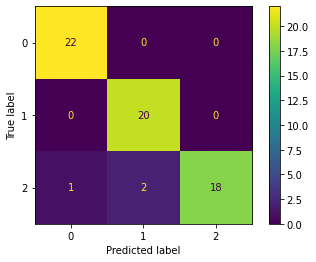



Model: KNeighborsClassifier
Fold: 1
Accuracy: 0.9803921568627451
Precision: 0.9814814814814815
Recall: 0.9803921568627452
F1 Score: 0.9803751803751805


Fold: 2
Accuracy: 0.9607843137254902
Precision: 0.9618736383442266
Recall: 0.9607843137254902
F1 Score: 0.9607673372379254


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 0.98
Precision: 0.9814814814814815
Recall: 0.9791666666666666
F1 Score: 0.9797235023041475


Fold: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Mean Metrics
Mean Accuracy: 0.9842352941176472
Mean Precision: 0.984967320261438
Mean Recall: 0.9840686274509803
Mean F1 Score: 0.9841732039834508
Best Estimator: 2
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.95      0.95      0.95        20
           2       0.95      0.95      0.95        21

    accuracy                           0.97        63
   macro avg       0.

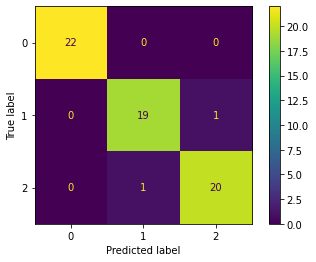



Model: DecisionTreeClassifier
Fold: 1
Accuracy: 0.8627450980392157
Precision: 0.8680555555555557
Recall: 0.8627450980392156
F1 Score: 0.8621519246519247


Fold: 2
Accuracy: 0.803921568627451
Precision: 0.8074074074074074
Recall: 0.8039215686274509
F1 Score: 0.8041666666666666


Fold: 3
Accuracy: 0.9
Precision: 0.9137254901960784
Recall: 0.8982843137254902
F1 Score: 0.9008643531970103


Fold: 4
Accuracy: 0.9
Precision: 0.9081527347781218
Recall: 0.8995098039215685
F1 Score: 0.901525054466231


Fold: 5
Accuracy: 0.96
Precision: 0.9618736383442266
Recall: 0.9607843137254902
F1 Score: 0.9595418470418471


Mean Metrics
Mean Accuracy: 0.8853333333333333
Mean Precision: 0.8918429652562778
Mean Recall: 0.8850490196078431
Mean F1 Score: 0.8856499692047359
Best Estimator: 4
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.79      0.95      0.86        20
           2       0.94      0.76      

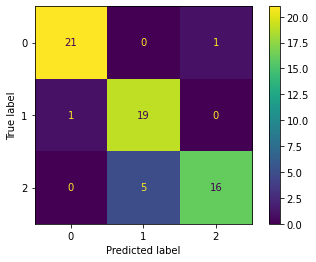



Model: LogisticRegression
Fold: 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 2
Accuracy: 0.9607843137254902
Precision: 0.9649122807017544
Recall: 0.9607843137254902
F1 Score: 0.9606481481481483


Fold: 3
Accuracy: 0.98
Precision: 0.9814814814814815
Recall: 0.9791666666666666
F1 Score: 0.9797235023041475


Fold: 4
Accuracy: 0.98
Precision: 0.9814814814814815
Recall: 0.9791666666666666
F1 Score: 0.9797235023041475


Fold: 5
Accuracy: 0.98
Precision: 0.9803921568627452
Recall: 0.9803921568627452
F1 Score: 0.9797979797979798


Mean Metrics
Mean Accuracy: 0.980156862745098
Mean Precision: 0.9816534801054925
Mean Recall: 0.9799019607843137
Mean F1 Score: 0.9799786265108846
Best Estimator: 0
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.95      1.00      0.98        20
           2       1.00      0.95      0.98        21

    accuracy                           0.98  

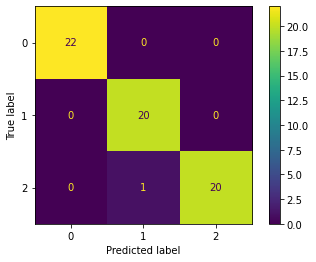



Model: GaussianNB
Fold: 1
Accuracy: 0.9411764705882353
Precision: 0.9444444444444443
Recall: 0.9411764705882352
F1 Score: 0.9410714285714286


Fold: 2
Accuracy: 0.9607843137254902
Precision: 0.9618736383442266
Recall: 0.9607843137254902
F1 Score: 0.9607673372379254


Fold: 3
Accuracy: 0.96
Precision: 0.9649122807017544
Recall: 0.9595588235294118
F1 Score: 0.9606277832084285


Fold: 4
Accuracy: 0.94
Precision: 0.9396514161220043
Recall: 0.9387254901960785
F1 Score: 0.9386102828228066


Fold: 5
Accuracy: 0.94
Precision: 0.9421296296296297
Recall: 0.9411764705882352
F1 Score: 0.9399881164587046


Mean Metrics
Mean Accuracy: 0.9483921568627451
Mean Precision: 0.9506022818484118
Mean Recall: 0.9482843137254902
Mean F1 Score: 0.9482129896598588
Best Estimator: 2
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       1.00      0.95      0.97        20
           2       0.95      0.95      0.95    

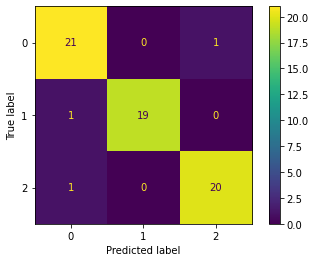

In [9]:
def train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test):
    models = [SVC(probability=True),KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression(),GaussianNB()]
    reports = {}
    for model in models:
        print(f"Model: {model.__class__.__name__}")
        if model.__class__.__name__ == "GaussianNB":
            X_train_tfidf = X_train_tfidf.toarray()
            X_test_tfidf = X_test_tfidf.toarray()
        best_estimator = cross_validate_and_train(model,X_train_tfidf,y_train)
        print(best_estimator.classes_)
        report = test_model(best_estimator,X_test_tfidf,y_test,plot=True)
        reports[model.__class__.__name__] = [best_estimator,report]
        print("\n")
    return reports
reports = train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test)

In [10]:
def choose_best_model(reports):
    #Choose best model based on highest accuracy, precision, recall and f1 score
    best_model = None
    best_score = 0
    model_name = None
    for model in reports:
        report = reports[model][1]
        score = report['accuracy'] + report['macro avg']['precision'] + report['macro avg']['recall'] + report['macro avg']['f1-score']
        if score > best_score:
            best_score = score
            best_model = reports[model][0]
            model_name = model
    return model_name, best_model
model_name, best_model = choose_best_model(reports)
print(f"Best Model: {model_name}")

Best Model: LogisticRegression


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.95      0.97        20
           2       0.95      1.00      0.98        21

    accuracy                           0.98        63
   macro avg       0.98      0.98      0.98        63
weighted avg       0.98      0.98      0.98        63



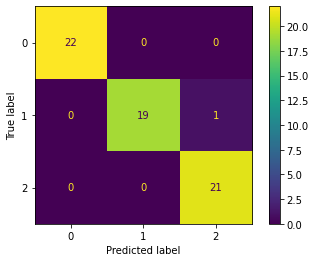

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf,y_train)
y_pred = knn.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=knn.classes_).plot()
plt.show()

In [12]:
probs = best_model.predict_proba(X_test_tfidf)
for prob in probs:
    print(prob)

[0.85624836 0.06769346 0.07605818]
[0.05081578 0.05240613 0.89677809]
[0.08788014 0.83521299 0.07690687]
[0.18451997 0.66505982 0.15042021]
[0.25343132 0.53438989 0.21217879]
[0.13413143 0.12715168 0.73871689]
[0.20592179 0.62585301 0.1682252 ]
[0.30942037 0.44847024 0.24210939]
[0.65272567 0.18073182 0.16654251]
[0.26340276 0.40301422 0.33358301]
[0.45938742 0.28220313 0.25840945]
[0.15332032 0.1153449  0.73133477]
[0.85312581 0.07181738 0.07505681]
[0.23297461 0.21384214 0.55318325]
[0.14506997 0.7257861  0.12914393]
[0.29783424 0.41145434 0.29071142]
[0.32328972 0.39649959 0.28021069]
[0.08411722 0.09537451 0.82050827]
[0.90785347 0.03434461 0.05780192]
[0.05081578 0.05240613 0.89677809]
[0.14562768 0.13996526 0.71440706]
[0.78893901 0.11650476 0.09455623]
[0.05081578 0.05240613 0.89677809]
[0.63100021 0.20209124 0.16690855]
[0.04145707 0.92504532 0.03349761]
[0.92560446 0.03973057 0.03466497]
[0.59112479 0.22261357 0.18626164]
[0.61073073 0.21303697 0.1762323 ]
[0.65477907 0.181479

In [13]:
# def save_model(model):
#     joblib.dump(model, "classifier.joblib")